# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [2]:
df = pd.read_csv("/content/loan_data_2007_2014.csv", low_memory=False)

# Data Understanding

## Isi

In [3]:
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(276210, 75)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276210 entries, 0 to 276209
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   276210 non-null  int64  
 1   id                           276210 non-null  int64  
 2   member_id                    276210 non-null  int64  
 3   loan_amnt                    276210 non-null  int64  
 4   funded_amnt                  276210 non-null  int64  
 5   funded_amnt_inv              276210 non-null  float64
 6   term                         276210 non-null  object 
 7   int_rate                     276210 non-null  float64
 8   installment                  276210 non-null  float64
 9   grade                        276210 non-null  object 
 10  sub_grade                    276210 non-null  object 
 11  emp_title                    259422 non-null  object 
 12  emp_length                   264787 non-null  object 
 13 

## Target

Target prediksi dapat didasarkan pada feature loan_status, tetapi dengan pengolahan terlebih dahulu.

In [6]:
df.loan_status.value_counts()

Fully Paid                                             137359
Current                                                100636
Charged Off                                             30050
Late (31-120 days)                                       3061
Does not meet the credit policy. Status:Fully Paid       1988
In Grace Period                                          1495
Does not meet the credit policy. Status:Charged Off       761
Late (16-30 days)                                         522
Default                                                   338
Name: loan_status, dtype: int64

loan_status yang tidak dibutuhkan untuk prediksi adalah 'Current' dan 'In Grace Period' karena belum diketahui berisiko bad loan atau good loan. Karena itu, data yang mengandung kedua value akan dihapus.

In [7]:
#membuang rows yang ada current dan in grace period
to_drop1 = ['Current', 'In Grace Period']
df = df[df.loan_status.isin(to_drop1) == False]

Dari value pada loan_status, status yang berkorelasi dengan good loan atau berisiko rendah adalah 'Fully Paid' dan 'Does not meet the credit policy. Status:Fully Paid'. Sisanya berkorelasi dengan bad loan. <br>

Karena itu, dilakukan mapping untuk penyederhanaan value. Good loan dilambangkan dengan integer 1, bad loan integer 0.

In [8]:
#memilah loan status
low_risk = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

#membuat kolom baru untuk mengklasifikasi
df['target'] = np.where(df['loan_status'].isin(low_risk), 1, 0)

In [9]:
df.shape

(174079, 76)

In [10]:
df['target'].value_counts()

1    139347
0     34732
Name: target, dtype: int64

In [11]:
df['target'].value_counts(normalize=True)

1    0.800481
0    0.199519
Name: target, dtype: float64

Melihat perbadingan data untuk kedua target. Terlihat dataset tidak seimbang. Nantinya akan dilakukan imbalance handling dengan upsampling dan downsampling.

# Eksplorasi

**STATUS PINJAMAN DAN TOTAL PEMBAYARAN YANG DITERIMA**

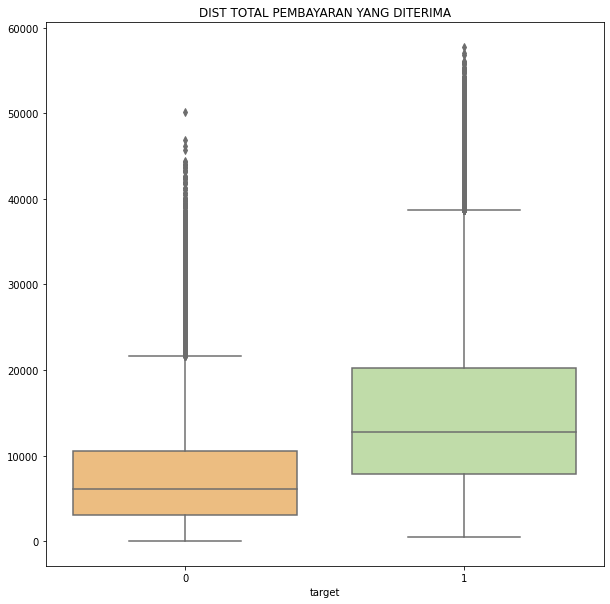

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,34732.0,7701.600269,6259.982536,0.00,3108.630,6055.075,10526.06250,50197.03000
1,139347.0,14989.642913,9471.797683,503.54,7836.125,12724.230,20185.36638,57777.57987


In [12]:
x = "target"
y = "total_pymnt"
plt.figure(figsize=(10,10))
sns.boxplot(data = df, x=x , y=y, palette = "Spectral")
plt.title("DIST TOTAL PEMBAYARAN YANG DITERIMA")
plt.ylabel("")
plt.show()

df.groupby(x)[y].describe()

Dapat dilihat dari plot diatas menunjukkan total pembayaran terbanyak ada pada pinjaman berstatus berhasil / baik

**STATUS PINJAMAN DAN JUMLAH PINJAMAN**

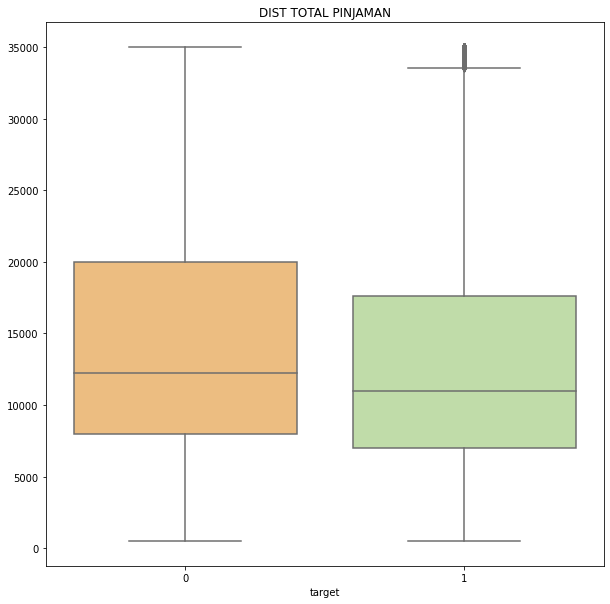

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,34732.0,14378.858114,8388.520166,500.0,8000.0,12200.0,20000.0,35000.0
1,139347.0,12861.747293,7821.436141,500.0,7000.0,11000.0,17600.0,35000.0


In [13]:
x = "target"
y = "loan_amnt"

plt.figure(figsize=(10,10))
sns.boxplot(data = df, x=x , y=y, palette = "Spectral")
plt.title("DIST TOTAL PINJAMAN")
plt.ylabel("")
plt.show()

df.groupby(x)[y].describe()

Jumlah pinjaman terbanyak ada pada status baik sedangkan rata rata nya berada pada status buruk

**TUJUAN MENGGUNAKAN PINJAMAN**

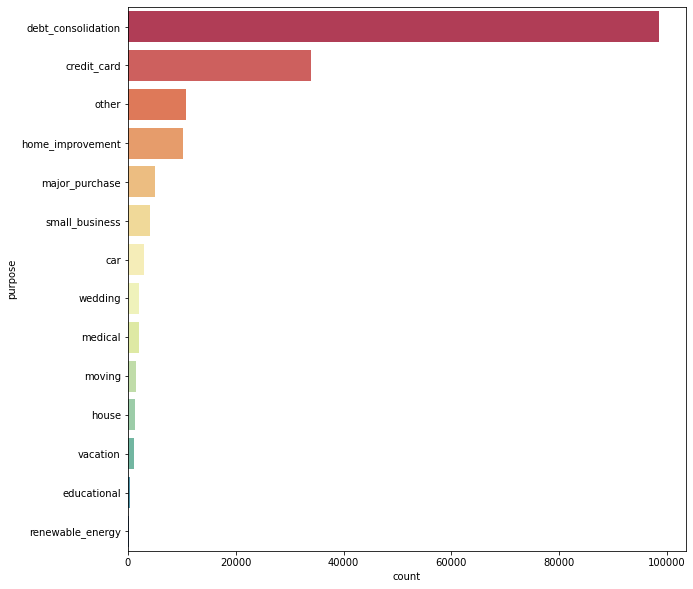

debt_consolidation    56.64%
credit_card           19.48%
other                  6.22%
home_improvement       5.88%
major_purchase         2.83%
small_business         2.36%
car                    1.72%
wedding                1.16%
medical                1.13%
moving                 0.85%
house                  0.73%
vacation               0.63%
educational            0.24%
renewable_energy       0.12%
Name: purpose, dtype: object


In [14]:
value_counts =df["purpose"].value_counts()

plt.figure(figsize=(10,10))
sns.countplot(y= "purpose", order = value_counts.index, data = df, palette = "Spectral")
plt.show()

percentage = value_counts / value_counts.sum()
percentage = percentage.apply("{:.2%}".format)
print(percentage)

Hampir 60% Peminjaman digunakan untuk menutup hutang sebelumnya, sedangkan tujuan lain antara lain untuk perbaikan rumah dan sedikit sekali digunakan untuk pendidikan, kesehatan maupun pembaruan energi

**NEGARA ASAL PEMINJAM**

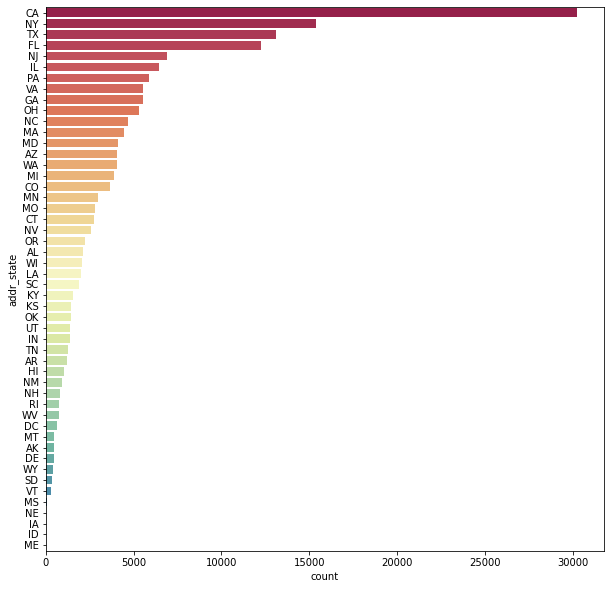

CA    17.39%
NY     8.85%
TX     7.52%
FL     7.05%
NJ     3.97%
IL     3.70%
PA     3.38%
VA     3.19%
GA     3.18%
OH     3.05%
NC     2.67%
MA     2.57%
MD     2.38%
AZ     2.34%
WA     2.32%
MI     2.23%
CO     2.10%
MN     1.70%
MO     1.59%
CT     1.58%
NV     1.48%
OR     1.29%
AL     1.20%
WI     1.18%
LA     1.16%
SC     1.09%
KY     0.88%
KS     0.84%
OK     0.83%
UT     0.80%
IN     0.79%
TN     0.71%
AR     0.70%
HI     0.59%
NM     0.53%
NH     0.45%
RI     0.44%
WV     0.44%
DC     0.36%
MT     0.28%
AK     0.28%
DE     0.26%
WY     0.23%
SD     0.21%
VT     0.15%
MS     0.05%
NE     0.01%
IA     0.01%
ID     0.01%
ME     0.00%
Name: addr_state, dtype: object


In [15]:
value_counts = df["addr_state"].value_counts()

plt.figure(figsize=(10,10))
sns.countplot(y= "addr_state",order=value_counts.index, data = df, palette = "Spectral")
plt.show()

percentage = value_counts / value_counts.sum()
percentage = percentage.apply("{:.2%}".format)
print(percentage)

Peminjam sebagian besar berasal dari negara California

**STATUS KEPEMILIKAN RUMAH**

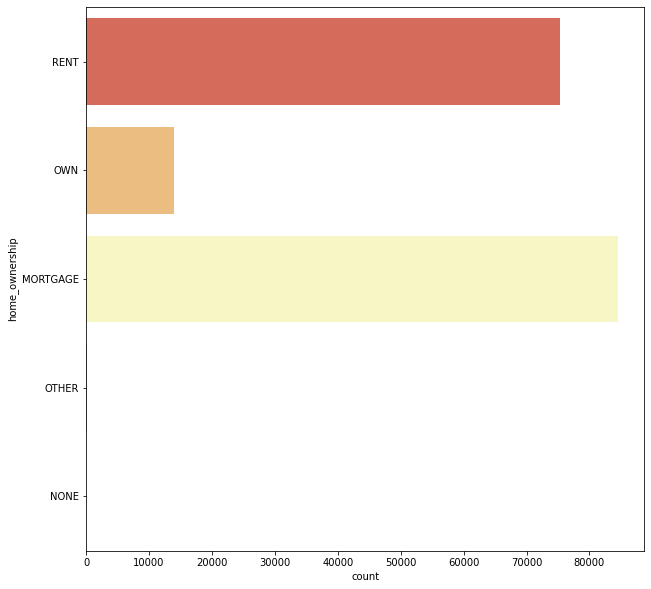

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(y= "home_ownership", data = df, palette = "Spectral")
plt.show()

Terlihat sebagian besar pinjaman mengalokasikan rumahnya sebagai pinjaman. Dan peminjam tampak sedikit yang memiliki rumah pribadi

**TINGKATAN PEMINJAMAN**

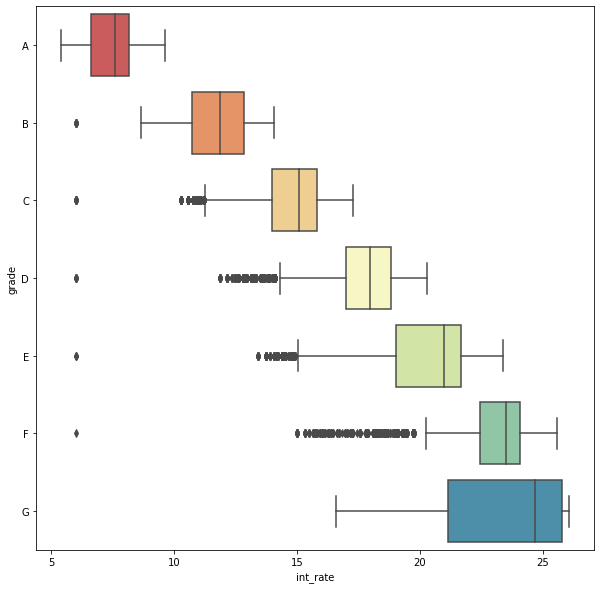

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,31271.0,7.544820,1.020310,5.42,6.62,7.62,8.19,9.63
B,55868.0,11.721499,1.286182,6.00,10.74,11.86,12.85,14.09
C,42821.0,14.944874,1.316102,6.00,13.99,15.10,15.81,17.27
D,26025.0,17.755380,1.596713,6.00,16.99,17.99,18.85,20.31
E,11671.0,20.241228,2.159514,6.00,19.03,21.00,21.70,23.40
F,5117.0,22.702378,2.247834,6.00,22.45,23.50,24.08,25.57
G,1306.0,23.465704,2.682848,16.59,21.14,24.70,25.80,26.06


In [17]:
x = "int_rate"
y = "grade"
order = df[y].sort_values().unique()
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x=x, y=y , order=order,palette = "Spectral")
plt.show()

df.groupby(y)[x].describe()

Suku bunga pinjaman dari Tingkat A hingga G terlihat meningkat yang artinya yang dibayarkan dari pinjaman sebelumnya lebih besar

# Preprocessing

## Missing Values Handling

In [18]:
df_null = df.isnull().sum().reset_index()
df_null.columns = ["features", "missing_value"]
df_null['Percentage'] = (df_null["missing_value"]/df.shape[0])*100
df_null.sort_values(by=['Percentage'], ascending = False).reset_index()

,index,features,missing_value,Percentage
0,61,open_il_6m,174079,100.0
1,66,il_util,174079,100.0
2,55,dti_joint,174079,100.0
3,56,verification_status_joint,174079,100.0
4,60,open_acc_6m,174079,100.0
...,...,...,...,...
71,39,total_pymnt,0,0.0
72,40,total_pymnt_inv,0,0.0
73,41,total_rec_prncp,0,0.0
74,42,total_rec_int,0,0.0


In [19]:
to_drop = df_null[df_null['Percentage']>25]['features']
to_drop

df.drop(to_drop, axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
df.shape

(174079, 50)

In [21]:
df_num = df.select_dtypes(include='number')

In [22]:
df_num.shape

(174079, 30)

In [23]:
to_fill = df_null[(df_null['Percentage']<=25) & (df_null['Percentage']>0)]['features']

Filling missing value untuk data numerik dilakukan dengan mean, sedangkan data nonnumerik dengan modus.

In [24]:
for feature in to_fill:
  if feature in df_num.columns:
    df[feature].fillna(int(df[feature].mean()), inplace = True)
  else:
    df[feature].fillna(str(df[feature].mode()), inplace = True)

In [25]:
print(df.isna().sum().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Pengecekan nilai duplikat juga dilakukan.

In [26]:
df.duplicated().sum()

0

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174079 entries, 0 to 276202
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          174079 non-null  int64  
 1   member_id                   174079 non-null  int64  
 2   loan_amnt                   174079 non-null  int64  
 3   funded_amnt                 174079 non-null  int64  
 4   funded_amnt_inv             174079 non-null  float64
 5   term                        174079 non-null  object 
 6   int_rate                    174079 non-null  float64
 7   installment                 174079 non-null  float64
 8   grade                       174079 non-null  object 
 9   sub_grade                   174079 non-null  object 
 10  emp_title                   174079 non-null  object 
 11  emp_length                  174079 non-null  object 
 12  home_ownership              174079 non-null  object 
 13  annual_inc    

## Feature Selection

In [28]:
df_obj = df.select_dtypes(include='object')

In [29]:
unique_obj = df_obj.nunique()
unique_num = df_num.nunique()

Mencari feature numerik dan nonnumerik yang hanya memiliki 1 nilai unik, memiliki nilai unik sesuai jumlah data, dan feature nonnumerik dengan nilai unik yang terlalu terbanyak (> 500). Feature akan dihapus nantinya.

In [30]:
single_obj_colname = unique_obj[unique_obj==1].index.to_list()
single_num_colname = unique_num[unique_num==1].index.to_list()

print(single_obj_colname)
print(single_num_colname)

['application_type']
['policy_code']


In [31]:
unique_obj_colname = unique_obj[unique_obj==df.shape[0]].index.to_list()
unique_num_colname = unique_num[unique_num==df.shape[0]].index.to_list()
print(unique_obj_colname)
print(unique_num_colname)

['url']
['id', 'member_id']


In [32]:
mul_obj_colname = unique_obj[unique_obj>500].index.to_list()
print(mul_obj_colname)

['emp_title', 'url', 'title', 'zip_code', 'earliest_cr_line']


In [33]:
remove = single_obj_colname + single_num_colname + unique_obj_colname + unique_num_colname + mul_obj_colname

In [34]:
new_df = df.loc[:, ~df.columns.isin(remove)].copy()
new_df.shape

(174079, 41)

In [35]:
new_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,target
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,861.07,0.00,0.00,0.00,Jan-15,171.62,Jan-16,0.0,0.0,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,0.0,0
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,603.65,0.00,0.00,0.00,Jun-14,649.91,Jan-16,0.0,0.0,1
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,2209.33,16.97,0.00,0.00,Jan-15,357.48,Jan-15,0.0,0.0,1
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,...,631.38,0.00,0.00,0.00,Jan-15,161.03,Sep-15,0.0,0.0,1


In [36]:
new_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'target'],
      dtype='object')

Ada beberapa infomasi feature yang dapat diprediksi secara langsung ketika kita melihat valuenya. Jika tidak dihapus, training model akan menghasilkan hasil yang bagus karena telah ada infomasi yang kita ingin prediksi, tetapi pada percobaan model sesungguhnya akan tidak baik karena adanya 'Data Leakage' tersebut. Feature yang termasuk 'Data Leakage' adalah:

* 'issue_d' : The month which the loan was funded
* 'loan_status' : Current status of the loan
* 'pymnt_plan' : payment plan
* 'out_prncp' : Remaining outstanding principal for total amount funded
* 'out_prncp_inv' : Remaining outstanding principal for portion of total amount funded by investors
* 'total_pymnt' : Payments received to date for total amount funded
* 'total_pymnt_inv' : Payments received to date for portion of total amount funded by investors
* 'total_rec_prncp' : Principal received to date
* 'total_rec_int' : Interest received to date
* 'total_rec_late_fee' : Late fees received to date
* 'recoveries' : Indicates if a payment plan has been put in place for the loan
* 'collection_recovery_fee' : post charge off collection fee
* 'last_pymnt_d' : Last month payment was received
* 'last_pymnt_amnt' : Last total payment amount received

In [37]:
#ini adalah list dari columns yang berisi data leakage
leak_col = ['issue_d', 'loan_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                   'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                   'last_pymnt_d', 'last_pymnt_amnt']

In [38]:
new_df.drop (columns=leak_col, axis=1, inplace=True)

In [39]:
new_df.drop (columns='sub_grade', axis=1, inplace=True)

In [40]:
new_df.drop (columns='last_credit_pull_d', axis=1, inplace=True)

In [41]:
new_df.shape

(174079, 26)

In [42]:
new_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'target'],
      dtype='object')

## Feature Engineering

In [43]:
new_df.select_dtypes(include ='object')

,term,grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,initial_list_status
0,36 months,B,10+ years,RENT,Verified,n,credit_card,AZ,f
1,60 months,C,< 1 year,RENT,Source Verified,n,car,GA,f
2,36 months,C,10+ years,RENT,Not Verified,n,small_business,IL,f
3,36 months,C,10+ years,RENT,Source Verified,n,other,CA,f
5,36 months,A,3 years,RENT,Source Verified,n,wedding,AZ,f
...,...,...,...,...,...,...,...,...,...
276183,36 months,B,10+ years,MORTGAGE,Verified,n,credit_card,FL,f
276185,36 months,D,7 years,RENT,Verified,n,small_business,VA,f
276187,60 months,C,6 years,MORTGAGE,Source Verified,n,debt_consolidation,FL,w
276193,60 months,C,4 years,RENT,Verified,n,debt_consolidation,WI,w


**Label encoding**<br>
Dilakukan label encoding untuk feature yang dapat direpresentasikan dengan nilai ordinal yang dipengaruhi peringkat.

In [44]:
new_df['term'].value_counts()

 36 months    139438
 60 months     34641
Name: term, dtype: int64

In [45]:
#1. Mengubah 'term'
new_df['term'] = new_df['term'].str.replace(' months', '').astype(int)

In [46]:
new_df['grade'].value_counts()

B    55868
C    42821
A    31271
D    26025
E    11671
F     5117
G     1306
Name: grade, dtype: int64

In [47]:
#2. Mengubah 'grade'
grade_new = {'A' : 1,'B' : 2,'C' : 3,'D' : 4,'E' : 5,'F' : 6,'G' : 7,}

new_df['grade'] = new_df['grade'].map(grade_new)

In [48]:
new_df['emp_length'].value_counts()

10+ years                        50071
2 years                          16579
< 1 year                         14947
3 years                          14316
5 years                          13587
1 year                           12027
4 years                          11675
6 years                          10825
7 years                           9750
8 years                           7769
9 years                           6304
0    10+ years\ndtype: object     6229
Name: emp_length, dtype: int64

In [49]:
#3. Mengubah 'emp_length'
empl_new = {'< 1 year' : 0,'1 year' : 1,'2 years' : 2,'3 years' : 3,'4 years' : 4,'5 years' : 5,'6 years' : 6, '7 years' : 7, '8 years' : 8, 'years' : 9, '0    10+ years\ndtype: object' : 10, '10+ years' : 10}
new_df['emp_length'] = new_df['emp_length'].map(empl_new)

In [50]:
new_df['home_ownership'].value_counts()

MORTGAGE    84460
RENT        75386
OWN         14006
OTHER         179
NONE           48
Name: home_ownership, dtype: int64

In [51]:
#4. Mengubah home ownership

home_new = {'NONE' : 'OTHER', 'ANY' : 'OTHER'}
new_df['home_ownership'] = new_df['home_ownership'].map(home_new)

In [52]:
new_df['initial_list_status'].value_counts()

f    145009
w     29070
Name: initial_list_status, dtype: int64

In [53]:
#5. Mengubah 'initial_list_status'
init_new = {'f' : 1, 'w' : 0}
new_df['initial_list_status'] = new_df['initial_list_status'].map(init_new)

**One-hot encoding**<br>
Dilakukan one-hot encoding untuk feature nonnumerik yang tidak dapat direpresentasikan dalam ordinal atau peringkat.

In [54]:
new_df['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

In [55]:
new_df['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [56]:
new_df['addr_state'].unique()

array(['AZ', 'GA', 'IL', 'CA', 'TX', 'VA', 'MO', 'CT', 'UT', 'FL', 'NY',
       'PA', 'MN', 'NJ', 'OR', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA', 'WA',
       'WI', 'AL', 'NV', 'AK', 'CO', 'MD', 'WV', 'VT', 'MI', 'DC', 'SD',
       'NC', 'AR', 'NM', 'KS', 'HI', 'OK', 'MT', 'WY', 'NH', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME'], dtype=object)

In [57]:
#One hot encoding
onehot = ['verification_status', 'purpose', 'addr_state']

dummy = pd.get_dummies(new_df[onehot])

Memilih feature numerik yang memiliki korelasi positif 5 teratas dan negatif 4 teratas terhadap feature target.

In [58]:
new_df.corr()['target'][:].sort_values(ascending = True).head(5)

int_rate     -0.248112
grade        -0.239787
term         -0.177767
dti          -0.112771
revol_util   -0.098733
Name: target, dtype: float64

In [59]:
new_df.corr()['target'][:].sort_values(ascending = False).head(5)

target                 1.000000
annual_inc             0.054469
initial_list_status    0.026901
total_acc              0.018892
revol_bal             -0.002728
Name: target, dtype: float64

In [60]:
cor_col = ['target','int_rate','grade','term','dti','revol_util', 'annual_inc', 'initial_list_status', 'total_acc', 'revol_bal' ]

In [61]:
cor_df = new_df[cor_col].copy()

In [62]:
#menggabungkan data cor dan dummy
concat_df = pd.concat([cor_df, dummy], axis = 1)

In [63]:
concat_df.shape

(174079, 77)

## Imbalance Handling

In [64]:
concat_df['target'].value_counts()

1    139347
0     34732
Name: target, dtype: int64

In [65]:
concat_df['target'].value_counts(normalize= True)

1    0.800481
0    0.199519
Name: target, dtype: float64

Melakukan upsampling untuk target 0 atau bad loan, dan downsampling untuk target 1 atau good loan.

In [66]:
df_major = concat_df[(concat_df['target']==0)]
df_minor = concat_df[(concat_df['target']==1)]

df_minor_up = resample(df_minor, replace = True, n_samples = 119456, random_state = 42)
df_major_down = resample(df_major, replace = True, n_samples = 119456, random_state = 42)
df_upsampled = pd.concat([df_minor_up,df_major_down])

In [67]:
df_upsampled['target'].value_counts(normalize= True)

1    0.5
0    0.5
Name: target, dtype: float64

In [68]:
df_upsampled.head()

,target,int_rate,grade,term,dti,revol_util,annual_inc,initial_list_status,total_acc,revol_bal,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
217852,1,10.74,2,36,19.85,33.6,22000.0,1,11.0,3358.0,...,0,0,1,0,0,0,0,0,0,0
230539,1,14.27,3,60,18.74,95.0,88000.0,1,16.0,18998.0,...,0,0,0,0,0,0,0,0,0,0
194264,1,14.33,3,36,13.80,65.5,38000.0,1,9.0,9568.0,...,0,0,0,0,0,0,0,0,0,0
215135,1,6.62,1,36,4.23,20.4,125000.0,1,25.0,9010.0,...,0,0,0,0,0,0,0,0,0,0
202650,1,7.90,1,36,18.82,61.8,59500.0,1,42.0,15070.0,...,0,0,0,0,0,0,0,0,0,0


## Standardization

Melakukan standardisasi nilai dengan Standard Scaler agar rentang nilai dalam skala yang sama.

In [69]:
for i in df_upsampled.columns:
  scale = StandardScaler().fit(df_upsampled[[i]])
  df_upsampled[i] = scale.transform(df_upsampled[[i]])

In [70]:
df_upsampled.head()

,target,int_rate,grade,term,dti,revol_util,annual_inc,initial_list_status,total_acc,revol_bal,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
217852,1.0,-0.837065,-0.694477,-0.581932,0.404853,-0.962409,-0.915276,0.458505,-1.134267,-0.583454,...,-0.046929,-0.091996,3.582783,-0.087857,-0.181459,-0.036393,-0.15359,-0.107512,-0.063017,-0.045565
230539,1.0,-0.041966,0.029996,1.718413,0.261142,1.534940,0.377453,0.458505,-0.695630,0.172849,...,-0.046929,-0.091996,-0.279113,-0.087857,-0.181459,-0.036393,-0.15359,-0.107512,-0.063017,-0.045565
194264,1.0,-0.028452,0.029996,-0.581932,-0.378436,0.335074,-0.601887,0.458505,-1.309723,-0.283157,...,-0.046929,-0.091996,-0.279113,-0.087857,-0.181459,-0.036393,-0.15359,-0.107512,-0.063017,-0.045565
215135,1.0,-1.765057,-1.418950,-0.581932,-1.617457,-1.499298,1.102164,0.458505,0.093918,-0.310140,...,-0.046929,-0.091996,-0.279113,-0.087857,-0.181459,-0.036393,-0.15359,-0.107512,-0.063017,-0.045565
202650,1.0,-1.476749,-1.418950,-0.581932,0.271500,0.184582,-0.180771,0.458505,1.585287,-0.017097,...,-0.046929,-0.091996,-0.279113,-0.087857,-0.181459,-0.036393,-0.15359,-0.107512,-0.063017,-0.045565


# Modeling

Splitting data feature dan target untuk training dan testing.

In [71]:
#menentukan features dan target kita
X = df_upsampled.drop('target', axis = 1) #data features
y = df_upsampled['target'] #data target

In [72]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Model yang dibangun meliputi Decision Tree, Random Forest, XGBoost, dan KNN.

## Decision Tree

In [73]:
#Decision tree
dtree = DecisionTreeClassifier(random_state = 42)
dtree = dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        -1.0       0.86      0.96      0.90     29965
         1.0       0.95      0.84      0.89     29763

    accuracy                           0.90     59728
   macro avg       0.90      0.90      0.90     59728
weighted avg       0.90      0.90      0.90     59728



## Random Forest

In [74]:
#Random Forest
randof = RandomForestClassifier(random_state = 42)
randof.fit(x_train, y_train)
y_pred = randof.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.91      0.96      0.93     29965
         1.0       0.95      0.90      0.93     29763

    accuracy                           0.93     59728
   macro avg       0.93      0.93      0.93     59728
weighted avg       0.93      0.93      0.93     59728



## XGBoost

In [75]:
#XGBoost
xgb = XGBClassifier(random_state = 42)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65     29965
         1.0       0.65      0.64      0.65     29763

    accuracy                           0.65     59728
   macro avg       0.65      0.65      0.65     59728
weighted avg       0.65      0.65      0.65     59728



## KNN

In [76]:
#KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.71      0.81      0.75     29965
         1.0       0.77      0.66      0.71     29763

    accuracy                           0.73     59728
   macro avg       0.74      0.73      0.73     59728
weighted avg       0.74      0.73      0.73     59728



Model yang dipilih adalah Random Forest

# Hyperparameter Tuning

Dilakukan hyperparameter tuning untuk model terpilih Random Forest.

In [79]:
param = [
    {
        'max_depth': list(range(2,5))+[None],
        'max_features': ['sqrt','log2', None],
        'min_samples_leaf': list(range(2,5)),
        'min_samples_split': list(range(2,5)),
        'class_weight': [{0:1, 1:3.33,}, "balanced"]
    }
]

In [80]:
rscv_rf = RandomizedSearchCV(randof, param, cv = 2, n_jobs = -1, verbose= 0, random_state = 42, n_iter = 50)
rscv_rf.fit(x_train, y_train)
y_pred = rscv_rf.predict(x_test)

auc = roc_auc_score(y_test, y_pred)
klasif = classification_report(y_test, y_pred)

print("Testing AUC: {}".format(auc))
print("Testing Klasifikasi report: \n{}".format(klasif))

print("Best param: {}".format(rscv_rf.best_params_))

Testing AUC: 0.9142215526688875
Testing Klasifikasi report: 
              precision    recall  f1-score   support

        -1.0       0.89      0.94      0.92     29965
         1.0       0.94      0.89      0.91     29763

    accuracy                           0.91     59728
   macro avg       0.92      0.91      0.91     59728
weighted avg       0.92      0.91      0.91     59728

Best param: {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': None, 'class_weight': 'balanced'}
